# Lab: Regularizing MLPs

------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------

**Team Members**:
- Felipe Guzmán Rodríguez: 100535519@alumnos.uc3m.es
- Álvaro Alcalde Cid: 100428760@alumnos.uc3m.es
- Rubén Ribes Serrano: 100537798@alumnos.uc3m.es

In this lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets take a look to the mini-batch size and plot a sample.

In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

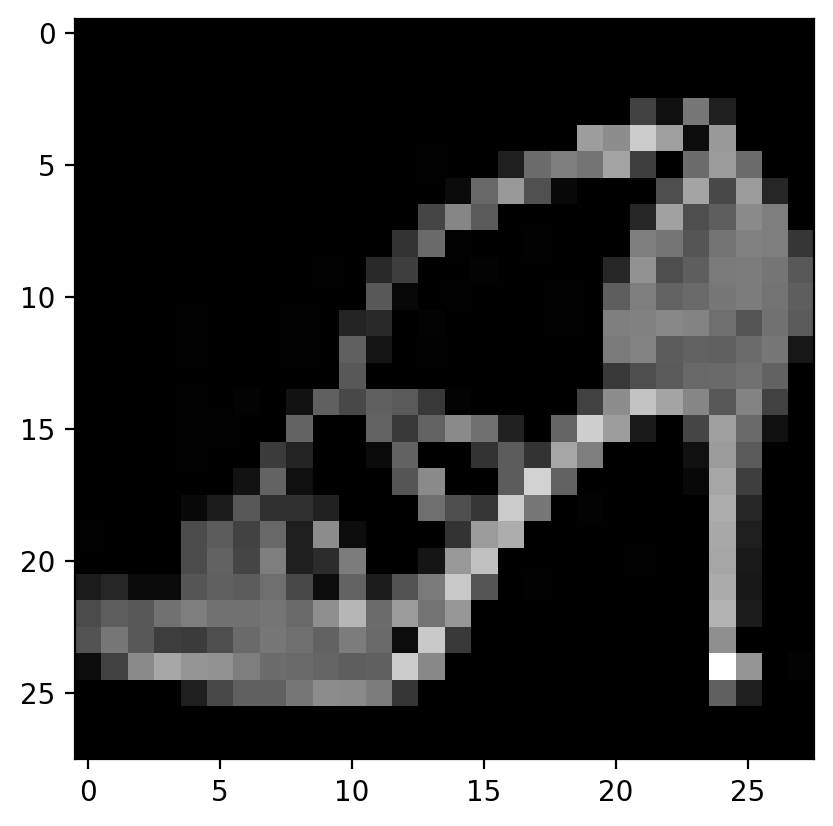

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [6]:
class MLP(nn.Module):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels):
        super().__init__()
        
        self.output1 = nn.Linear(dimx, hidden1)
        
        self.output2 = nn.Linear(hidden1, hidden2)
        
        self.output3 = nn.Linear(hidden2, hidden3)
        
        self.output4 = nn.Linear(hidden3, nlabels)
        
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        
        x = self.output2(x)
        x = self.relu(x)
        
        x = self.output3(x)
        x = self.relu(x)
        
        x = self.output4(x)
        x = self.logsoftmax(x)
        
        return x
        

In [7]:
#YOUR CODE HERE
class MLP_extended(MLP):
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=100,lr=0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        
    def trainloop(self, trainloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0
            
            self.optim.zero_grad()
            out = self.forward(images.view(images.shape[0], -1))
            loss = self.criterion(out, labels)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
            
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0):

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def evaluate(self, trainloader):
        accuracy = 0
        with torch.no_grad():

            for images,labels in trainloader:
        
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        return accuracy / len(trainloader)

In [8]:
#YOUR CODE HERE
mlp_extended = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=30,lr=1e-3)
mlp_extended.trainloop(trainloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}")

Training loss after 0 epochs: 0.002447
Training loss after 1 epochs: 0.002386
Training loss after 2 epochs: 0.002321
Training loss after 3 epochs: 0.002234
Training loss after 4 epochs: 0.002130
Training loss after 5 epochs: 0.002008
Training loss after 6 epochs: 0.001870
Training loss after 7 epochs: 0.001722
Training loss after 8 epochs: 0.001569
Training loss after 9 epochs: 0.001410
Training loss after 10 epochs: 0.001254
Training loss after 11 epochs: 0.001107
Training loss after 12 epochs: 0.000972
Training loss after 13 epochs: 0.000850
Training loss after 14 epochs: 0.000744
Training loss after 15 epochs: 0.000651
Training loss after 16 epochs: 0.000572
Training loss after 17 epochs: 0.000507
Training loss after 18 epochs: 0.000449
Training loss after 19 epochs: 0.000398
Training loss after 20 epochs: 0.000355
Training loss after 21 epochs: 0.000315
Training loss after 22 epochs: 0.000279
Training loss after 23 epochs: 0.000246
Training loss after 24 epochs: 0.000218
Training l

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [9]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [10]:
#YOUR CODE HERE
class MLP_extended(MLP):
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            running_loss = 0

            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            valid_loss = 0
            with torch.no_grad():
                for images, labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()
            self.valid_loss_during_training.append(valid_loss / len(validloader))

            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}")

    def evaluate(self, dataloader):
        accuracy = 0
        with torch.no_grad():
            for images, labels in dataloader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        return accuracy / len(dataloader)


In [11]:
#YOUR CODE HERE
mlp_extended = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=1e-3)
mlp_extended.trainloop(trainloader, validloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")


Epoch 1/30.. Training loss: 0.550.. Validation loss: 0.432
Epoch 2/30.. Training loss: 0.395.. Validation loss: 0.416
Epoch 3/30.. Training loss: 0.358.. Validation loss: 0.386
Epoch 4/30.. Training loss: 0.325.. Validation loss: 0.342
Epoch 5/30.. Training loss: 0.306.. Validation loss: 0.336
Epoch 6/30.. Training loss: 0.288.. Validation loss: 0.332
Epoch 7/30.. Training loss: 0.274.. Validation loss: 0.342
Epoch 8/30.. Training loss: 0.258.. Validation loss: 0.349
Epoch 9/30.. Training loss: 0.248.. Validation loss: 0.345
Epoch 10/30.. Training loss: 0.236.. Validation loss: 0.343
Epoch 11/30.. Training loss: 0.222.. Validation loss: 0.333
Epoch 12/30.. Training loss: 0.215.. Validation loss: 0.331
Epoch 13/30.. Training loss: 0.205.. Validation loss: 0.356
Epoch 14/30.. Training loss: 0.195.. Validation loss: 0.366
Epoch 15/30.. Training loss: 0.186.. Validation loss: 0.342
Epoch 16/30.. Training loss: 0.179.. Validation loss: 0.354
Epoch 17/30.. Training loss: 0.171.. Validation l

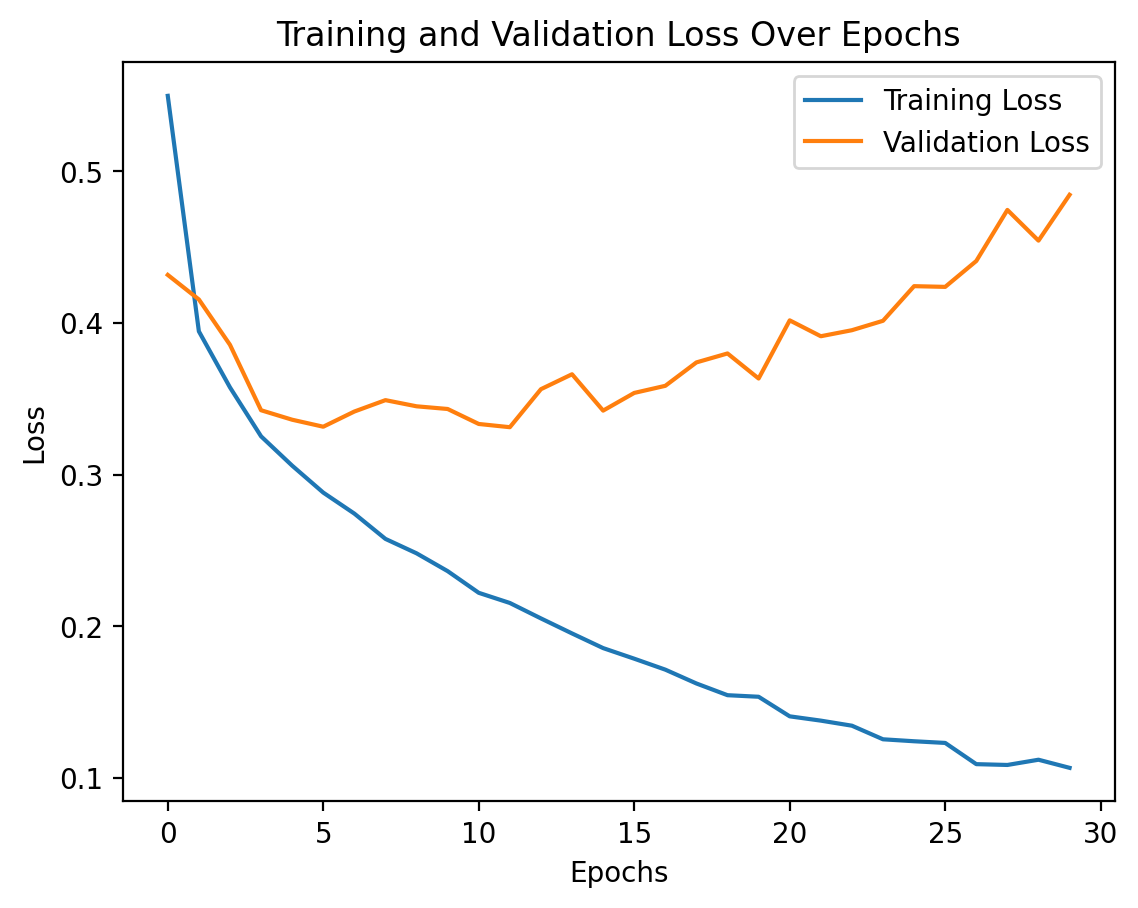

Train Evaluation: 0.9583, Test Evaluation: 0.8747, Validation Evaluation: 0.8819


In [12]:
#YOUR CODE HERE
plt.plot(mlp_extended.loss_during_training, label='Training Loss')
plt.plot(mlp_extended.valid_loss_during_training, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

Epoch 1/10.. Training loss: 0.550.. Validation loss: 0.474
Epoch 2/10.. Training loss: 0.397.. Validation loss: 0.384
Epoch 3/10.. Training loss: 0.351.. Validation loss: 0.360
Epoch 4/10.. Training loss: 0.323.. Validation loss: 0.367
Epoch 5/10.. Training loss: 0.303.. Validation loss: 0.342
Epoch 6/10.. Training loss: 0.287.. Validation loss: 0.335
Epoch 7/10.. Training loss: 0.272.. Validation loss: 0.342
Epoch 8/10.. Training loss: 0.262.. Validation loss: 0.324
Epoch 9/10.. Training loss: 0.246.. Validation loss: 0.378
Epoch 10/10.. Training loss: 0.237.. Validation loss: 0.341
Train Evaluation: 0.9173, Test Evaluation: 0.8762, Validation Evaluation: 0.8830


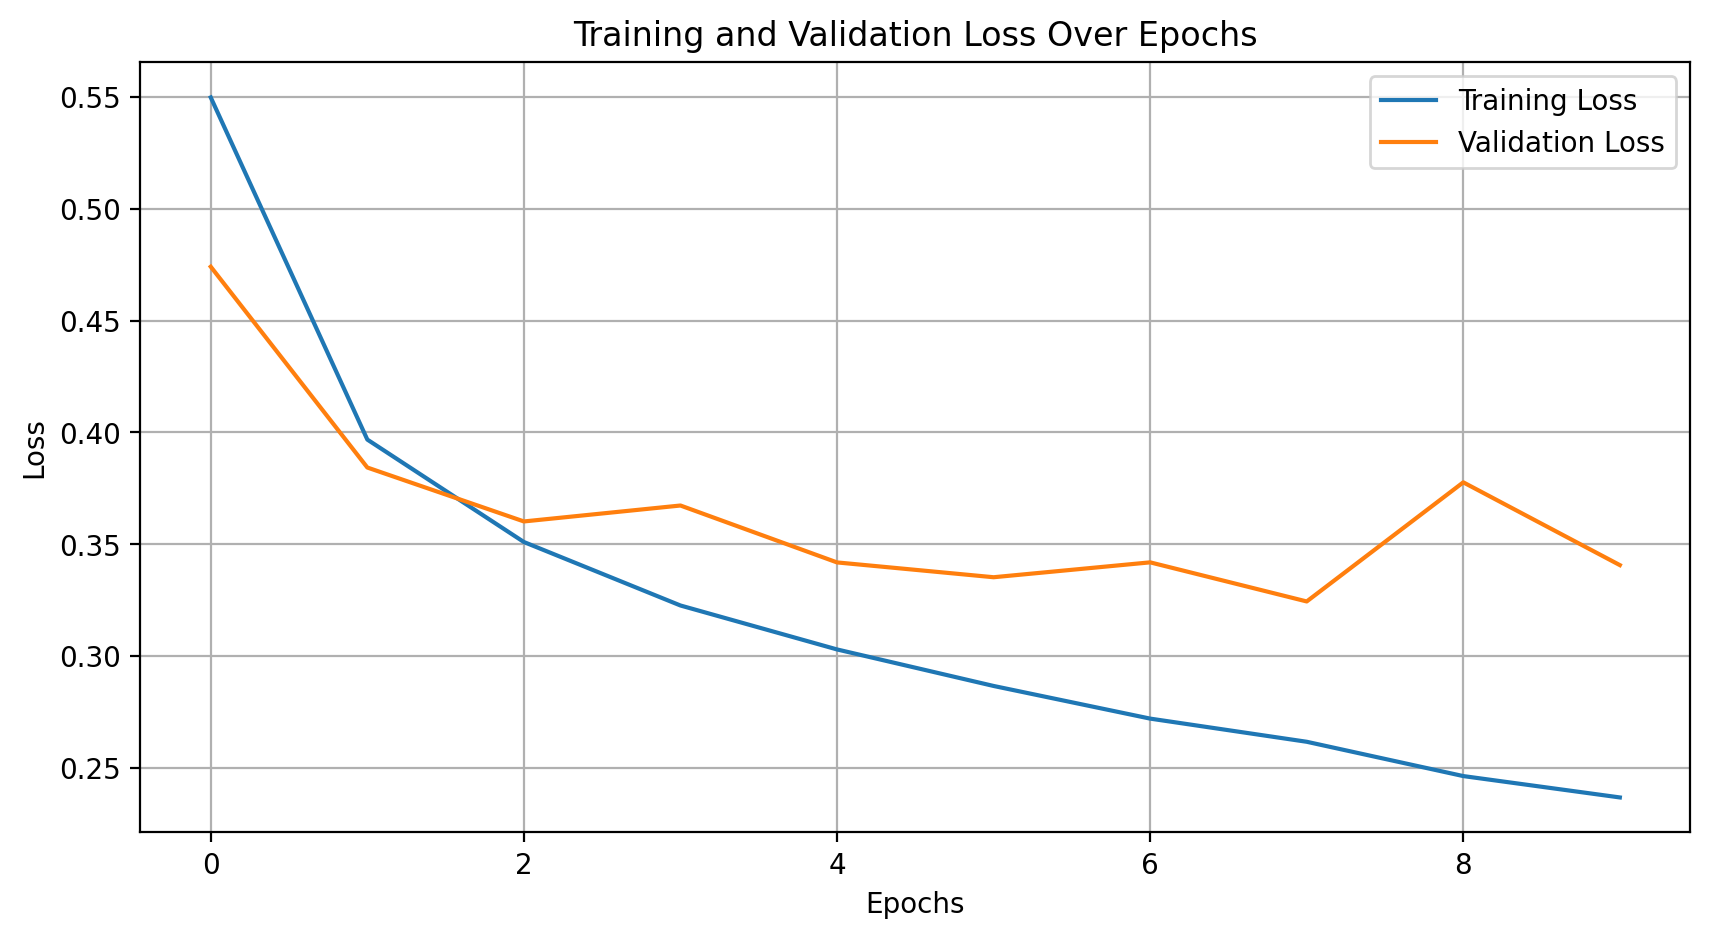

In [13]:
#YOUR CODE HERE
mlp_extended = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=10, lr=1e-3)
mlp_extended.trainloop(trainloader, validloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mlp_extended.loss_during_training, label='Training Loss')
plt.plot(mlp_extended.valid_loss_during_training, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [14]:
class MLPdrop(nn.Module):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, dropout=0.2):
        super().__init__()
        
        self.output1 = nn.Linear(dimx, hidden1)
        
        self.output2 = nn.Linear(hidden1, hidden2)
        
        self.output3 = nn.Linear(hidden2, hidden3)
        
        self.output4 = nn.Linear(hidden3, nlabels)
        
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
            x = self.output1(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output2(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output3(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output4(x)
            x = self.logsoftmax(x)
            
            return x

In [15]:
class MLPdrop_extended(MLPdrop):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=100, lr=0.001, dropout=0.2):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels, dropout=dropout)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = [] 

    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            running_loss = 0
            self.train()
            
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))
            
            valid_loss = 0 
            with torch.no_grad():
                self.eval()  
                
                for images, labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()
            self.valid_loss_during_training.append(valid_loss / len(validloader))

            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}")

    def evaluate(self, dataloader):
        accuracy = 0
        
        with torch.no_grad():
            self.eval()  
            
            for images, labels in dataloader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        print(f"Accuracy: {accuracy / len(dataloader):.3f}")

In [16]:
#YOUR CODE HERE
mlpdrop_extended = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=1e-3, dropout=0.2)
mlpdrop_extended.trainloop(trainloader, validloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

Epoch 1/30.. Training loss: 0.637.. Validation loss: 0.456
Epoch 2/30.. Training loss: 0.450.. Validation loss: 0.407
Epoch 3/30.. Training loss: 0.411.. Validation loss: 0.379
Epoch 4/30.. Training loss: 0.385.. Validation loss: 0.362
Epoch 5/30.. Training loss: 0.367.. Validation loss: 0.357
Epoch 6/30.. Training loss: 0.351.. Validation loss: 0.358
Epoch 7/30.. Training loss: 0.340.. Validation loss: 0.351
Epoch 8/30.. Training loss: 0.332.. Validation loss: 0.347
Epoch 9/30.. Training loss: 0.317.. Validation loss: 0.331
Epoch 10/30.. Training loss: 0.306.. Validation loss: 0.341
Epoch 11/30.. Training loss: 0.302.. Validation loss: 0.332
Epoch 12/30.. Training loss: 0.300.. Validation loss: 0.321
Epoch 13/30.. Training loss: 0.290.. Validation loss: 0.324
Epoch 14/30.. Training loss: 0.284.. Validation loss: 0.335
Epoch 15/30.. Training loss: 0.278.. Validation loss: 0.335
Epoch 16/30.. Training loss: 0.272.. Validation loss: 0.336
Epoch 17/30.. Training loss: 0.266.. Validation l

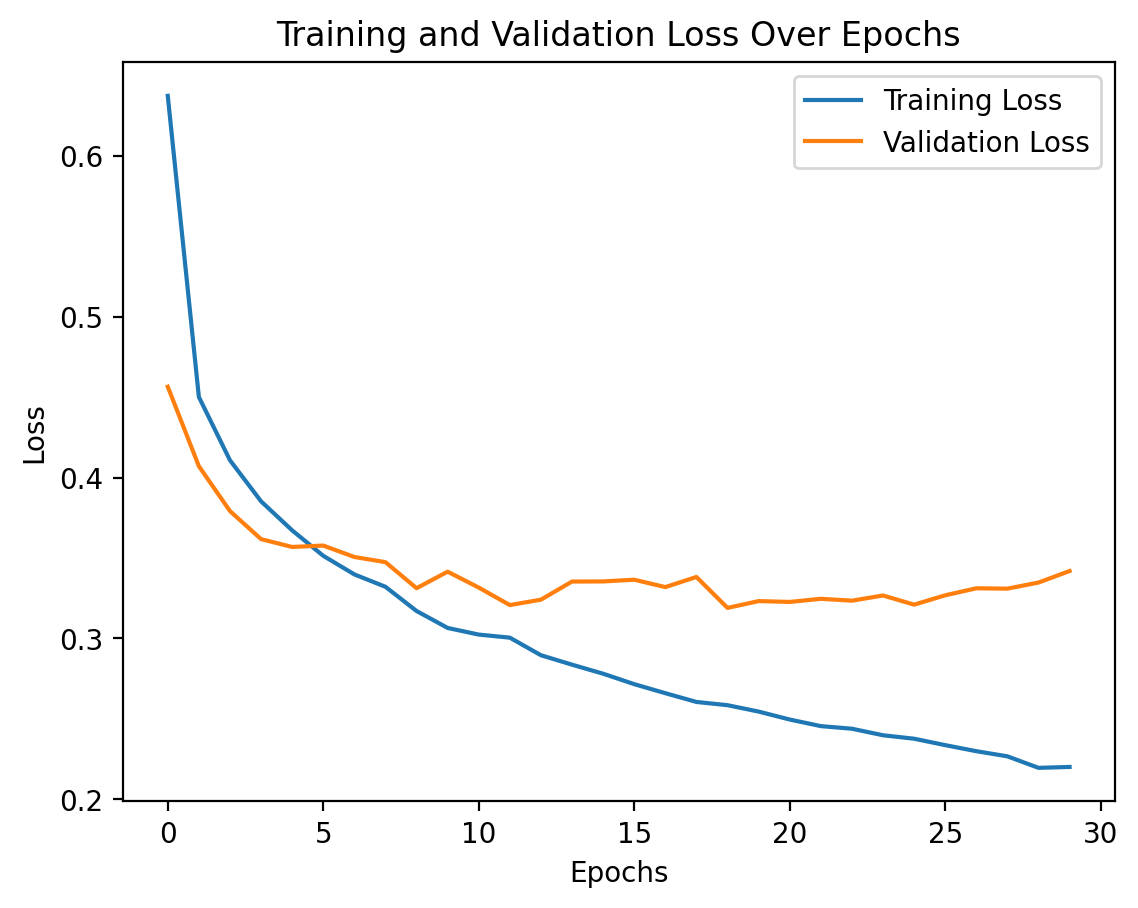

Train Evaluation: 0.9171, Test Evaluation: 0.8747, Validation Evaluation: 0.8825


In [17]:
#YOUR CODE HERE
plt.plot(mlpdrop_extended.loss_during_training, label='Training Loss')
plt.plot(mlpdrop_extended.valid_loss_during_training, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs, 0.2 Dropout')
plt.show()

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

 > For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.

**ANSWER**: As shown in the previous plot, the training and validation losses exhibit similar trends. To determine if early stopping is needed, we should look for an increase in the validation loss at a certain epoch. In this case, the validation loss does not increase over time, so early stopping is not necessary. If the validation loss were to rise at some point, early stopping would be beneficial at that specific epoch.

As expected, the accuracy metric performs better on the training set compared to the validation and test sets, which show slightly lower but similar performance.

The use of dropout reduces dependencies between units, effectively preventing overfitting. In previous cases without dropout, overfitting was evident as the validation loss increased with more epochs. The dropout technique has successfully mitigated this issue in the current scenario.

Epoch 1/30.. Training loss: 0.593.. Validation loss: 0.450
Epoch 2/30.. Training loss: 0.426.. Validation loss: 0.399
Epoch 3/30.. Training loss: 0.381.. Validation loss: 0.359
Epoch 4/30.. Training loss: 0.353.. Validation loss: 0.359
Epoch 5/30.. Training loss: 0.334.. Validation loss: 0.348
Epoch 6/30.. Training loss: 0.318.. Validation loss: 0.360
Epoch 7/30.. Training loss: 0.305.. Validation loss: 0.356
Epoch 8/30.. Training loss: 0.294.. Validation loss: 0.336
Epoch 9/30.. Training loss: 0.285.. Validation loss: 0.324
Epoch 10/30.. Training loss: 0.275.. Validation loss: 0.337
Epoch 11/30.. Training loss: 0.268.. Validation loss: 0.321
Epoch 12/30.. Training loss: 0.258.. Validation loss: 0.335
Epoch 13/30.. Training loss: 0.251.. Validation loss: 0.335
Epoch 14/30.. Training loss: 0.245.. Validation loss: 0.333
Epoch 15/30.. Training loss: 0.235.. Validation loss: 0.321
Epoch 16/30.. Training loss: 0.234.. Validation loss: 0.317
Epoch 17/30.. Training loss: 0.222.. Validation l

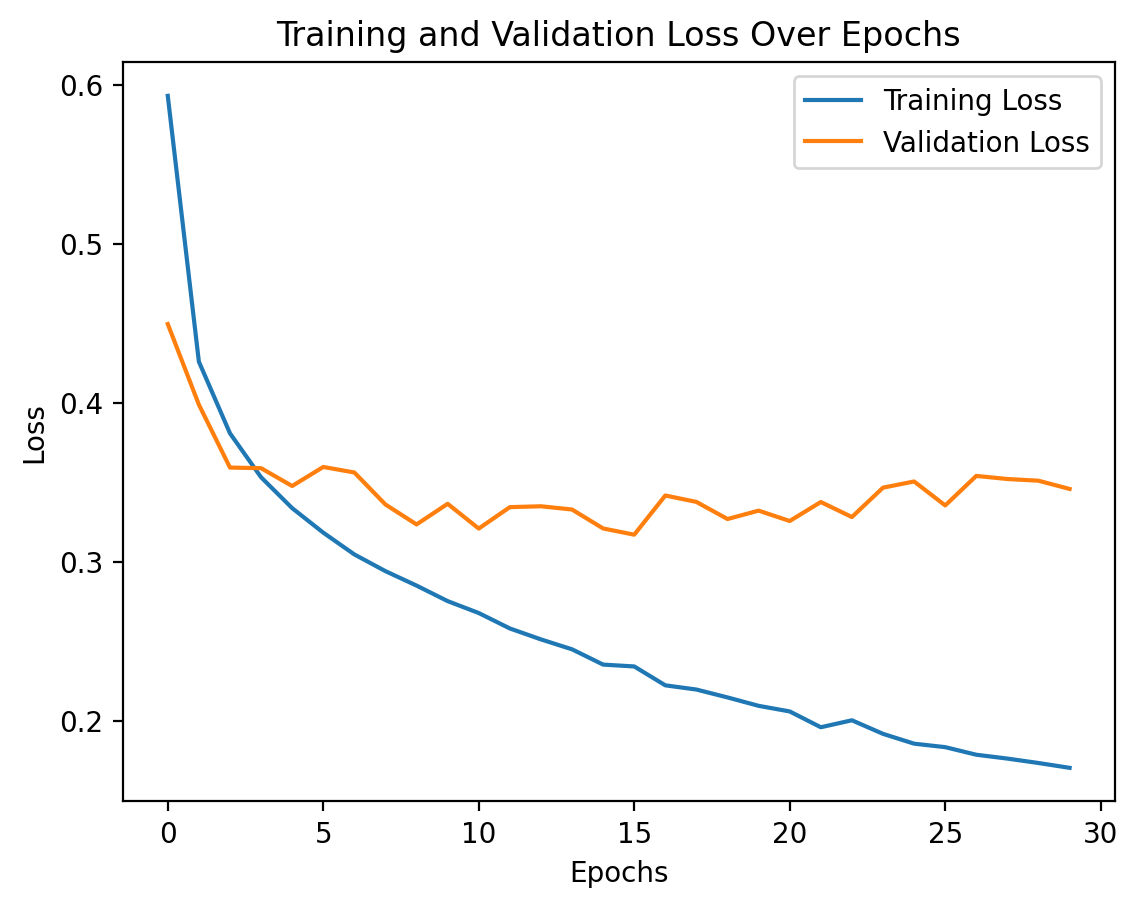

In [18]:
#YOUR CODE HERE
mlpdrop_extended = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=1e-3, dropout=0.1)
mlpdrop_extended.trainloop(trainloader, validloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

plt.plot(mlpdrop_extended.loss_during_training, label='Training Loss')
plt.plot(mlpdrop_extended.valid_loss_during_training, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs, 0.1 Dropout')
plt.show()

Epoch 1/30.. Training loss: 0.691.. Validation loss: 0.481
Epoch 2/30.. Training loss: 0.491.. Validation loss: 0.412
Epoch 3/30.. Training loss: 0.451.. Validation loss: 0.410
Epoch 4/30.. Training loss: 0.425.. Validation loss: 0.377
Epoch 5/30.. Training loss: 0.405.. Validation loss: 0.366
Epoch 6/30.. Training loss: 0.389.. Validation loss: 0.367
Epoch 7/30.. Training loss: 0.377.. Validation loss: 0.359
Epoch 8/30.. Training loss: 0.368.. Validation loss: 0.340
Epoch 9/30.. Training loss: 0.357.. Validation loss: 0.342
Epoch 10/30.. Training loss: 0.351.. Validation loss: 0.331
Epoch 11/30.. Training loss: 0.341.. Validation loss: 0.333
Epoch 12/30.. Training loss: 0.336.. Validation loss: 0.339
Epoch 13/30.. Training loss: 0.328.. Validation loss: 0.341
Epoch 14/30.. Training loss: 0.320.. Validation loss: 0.340
Epoch 15/30.. Training loss: 0.322.. Validation loss: 0.325
Epoch 16/30.. Training loss: 0.312.. Validation loss: 0.328
Epoch 17/30.. Training loss: 0.311.. Validation l

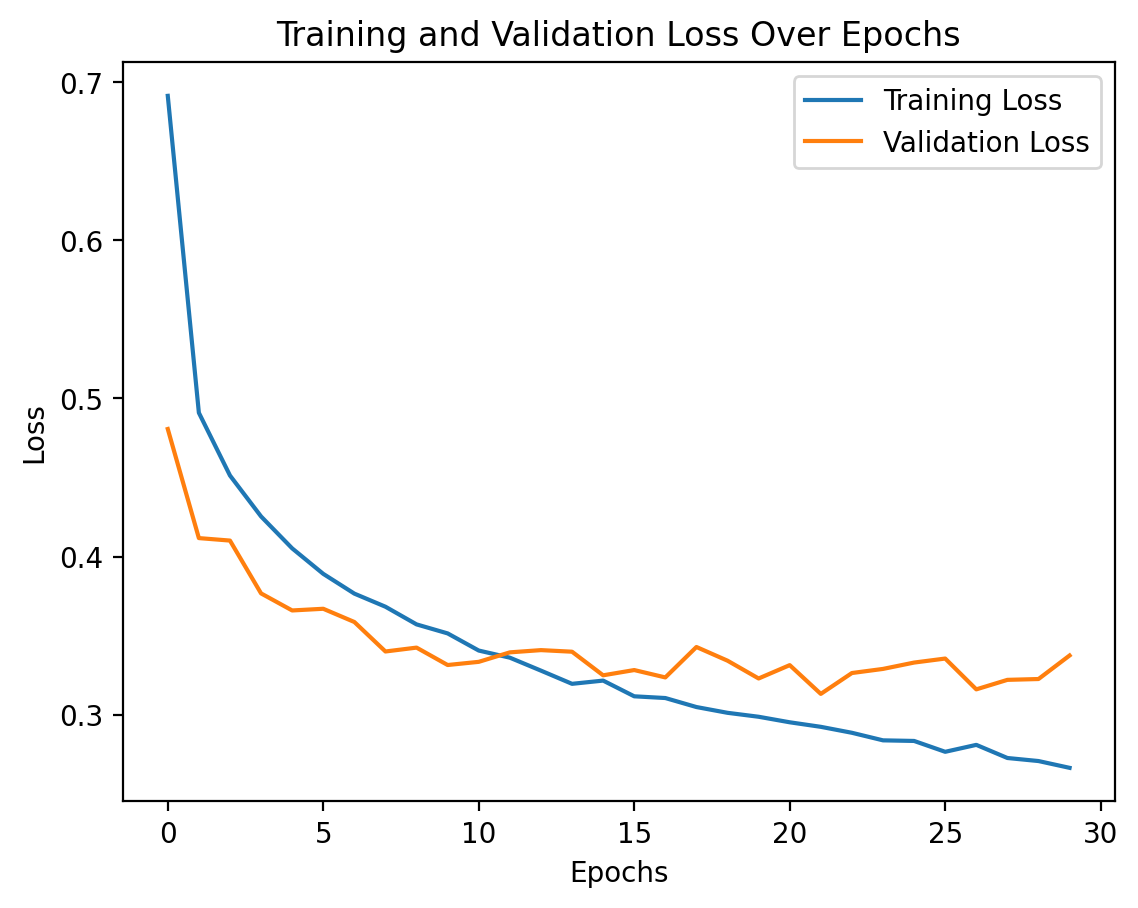

In [19]:
#YOUR CODE HERE
mlpdrop_extended = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=1e-3, dropout=0.3)
mlpdrop_extended.trainloop(trainloader, validloader)

train_accuracy = mlp_extended.evaluate(trainloader)
test_accuracy = mlp_extended.evaluate(testloader)
valid_accuracy = mlp_extended.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

plt.plot(mlpdrop_extended.loss_during_training, label='Training Loss')
plt.plot(mlpdrop_extended.valid_loss_during_training, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs, 0.3 Dropout')
plt.show()

> Which value provides the best validation performance?

ANSWER: The model with a dropout rate of 0.3 provides the best validation performance because it effectively regularizes the model, preventing overfitting while still retaining sufficient information during training. Although both dropout values are similar, it can be seen that at dropout = 0.1, the validation loss starts to slightly increase, indicating early signs of overfitting. For this reason, the 0.3 value works slightly better for this model.